# Time Series End-to-End Example

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data_prophet, split_store_data
from summarize import df_summary

# mySQL `tsa_item_demand` database
df = get_store_data()
df = prep_store_data_prophet(df)
train, test = split_store_data(df, train_prop=.66)


## Explore

### Total sales

#### Daily

Visualize how daily sales shift throughout the year.  

We will total the sales for each day and plot.  

- set_index('ds')
- resample('D')
- sum()

What do you think those sharp dips are? 

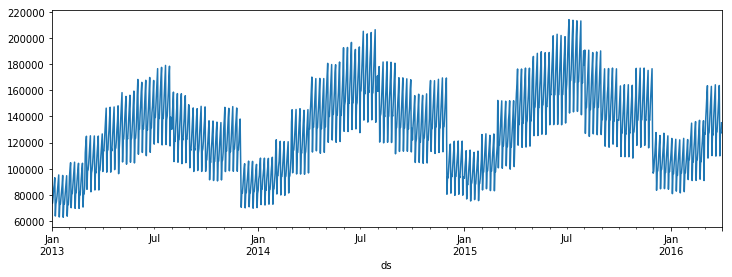

In [15]:
train.set_index('ds').resample('D').sum().loc[:'2016-03-31'].plot(figsize=(12, 4), legend=False)
plt.show()

#### Weekly

Visualize how weekly sales shift throughout the year.  

We will total the sales for each week and plot. 

- set_index('ds')
- resample('W')
- sum()

What do you think those sharp dips are? 

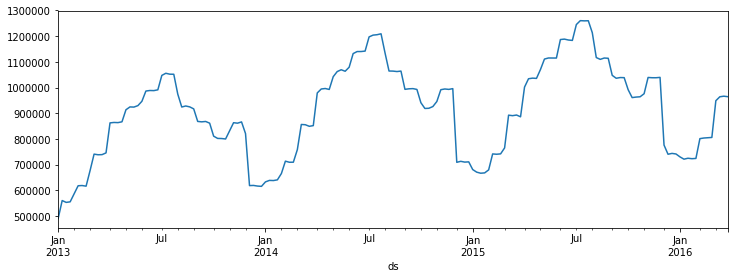

In [16]:
train.set_index('ds').resample('W').sum().loc[:'2016-03-31'].plot(figsize=(12, 4), legend=False)
plt.show()

#### Monthly

Visualize how monthly sales shift throughout the year.  

We will total the sales for each month and plot. 

- set_index('ds')
- resample('MS')
- sum()

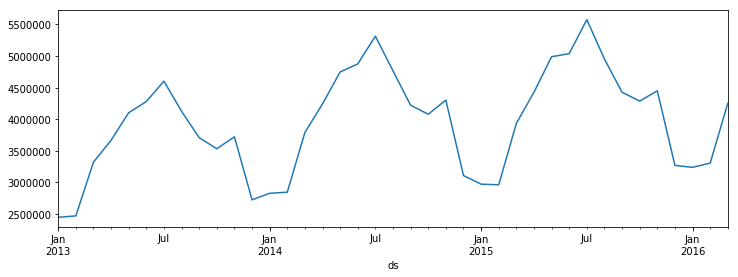

In [17]:
train.set_index('ds').resample('MS').sum().loc[:'2016-03-31'].plot(figsize=(12, 4), legend=False)
plt.show()

### Average Sales

#### Moving average of weekly total sales

1. Resample weekly, summing the existing daily values.  
2. Compute and plot the 8 week moving average, using `rolling()` and `plot()`.  
3. We will set min_periods=8, the number of periods we are averaging. This is the default action...to have null values up until there the number of periods being averaged. If we were to set it to 1, the behavior would be to use the number of weeks available to average, up to 8. So, week 1 will return its own value. Week 2 will be the average of weeks 1 & 2. Week 8 will be the average of weeks 1-8. And week 9 will be the average of weeks 2-9.  Because we are not averaging until we reach 8 weeks and will ultimately end up with 7 weeks of null values, we will end our script with a dropna() function.  

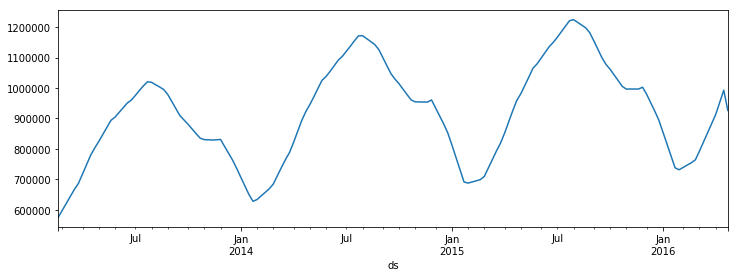

In [18]:
train_weekly_rolling_mean = train.set_index('ds').resample('W').sum().rolling(8, min_periods=8).mean().dropna()
train_weekly_rolling_mean.plot(figsize=(12, 4), legend=False)
plt.show()

#### Takeaways

- Now that so much noise is removed, it is much easier to see the trend and the seasonality.    
- Weekly sales increase steadily until July, after which, weekly sales decrease steadily until just after the start of the new year. 
- Despite the steady decrease over the last half of the year, we see a period with no dropping during November-December, likely due to the holiday season.  

So, for a refresher, this is currently what our moving averages look like in the dataframe:  

In [19]:
train_weekly_rolling_mean.head()

,y
ds,
2013-02-24,574616.24000
2013-03-03,597873.70250
2013-03-10,620468.27250
2013-03-17,643647.34875
2013-03-24,666627.04500


We can see now, after computing 8-week moving averages and dropping the first 7 weeks, we are left with a start date of 2013-02-24. 



### Visualize year-over-year differences in weekly sales

We can also compute a year-over-year difference of each week's value, which is represented as the the average weekly sales for the previous 8 weeks. We could use that difference to predict the next year, if we would like to try that out. This will help us see the year over year growth trend.  

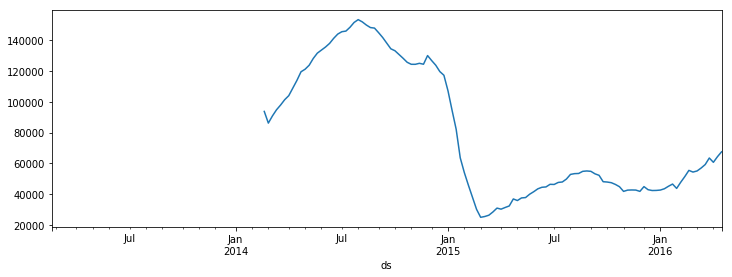

In [20]:
train_weekly_rolling_mean.diff(periods=52).iloc[:-1].plot(figsize=(12,4), legend=False)
plt.show()

#### Takeaways

- Frowth from 2013 to 2014 is significantly more than that from 2014 to 2015.  
- While year-over-year continues to grow, the amount of growth is less.  
- What we have basically done here is remove the seasonality from the equation and are just looking at the trend. 
- If we were to view 26 periods instead of 52, would we see the seasonality still exists? 


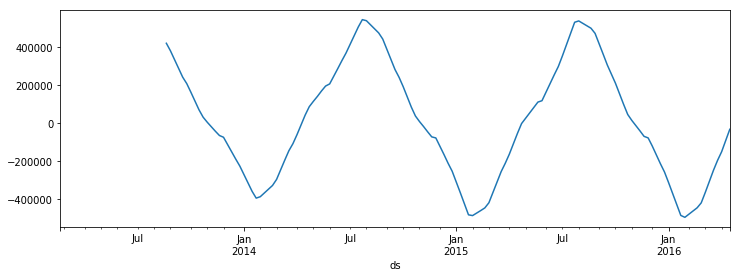

In [21]:
train_weekly_rolling_mean.diff(periods=26).iloc[:-1].plot(figsize=(12,4), legend=False)
plt.show()

#### Takeaways

- YES!
- Remember how we saw a steady increase in sales in the first half of the year, and then a mostly-steady decrease in the last half? That is made clearer in this visualization. 


### Seasonal Decomposition

Extrapolate and visualize the trend, annual seasonality and residuals from the observed values. 


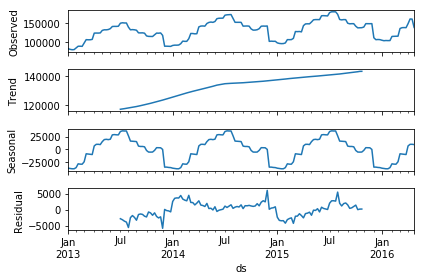

In [22]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train.set_index('ds').resample('W').mean()).plot()
plt.show()

#### Takeaways

- Looking at trend, growth was faster up to July, 2014, and then slowed down through the end of our sample date range.  
- Looking at the seasonal pattern, we see a pattern happening annually. It looks like there is a regular pattern of sharp increase and then decrease surrounding the November-December holiday season. Then sales increase throughout the year, maxing likely around the 4th of July holiday.  
- I would guess that seasonality also exists on a weekly cycle, given customer grocery shopping behaviors I am aware of. Let's see if we can visualize this.  

### Weeky Seasonality

Are there patterns that exist from day to day within each week?

Seasonality definitely exists at the week level. Let's try to visualize that by plotting the day-over-day differences. This should help us see the patterns that exist within the weeks. 

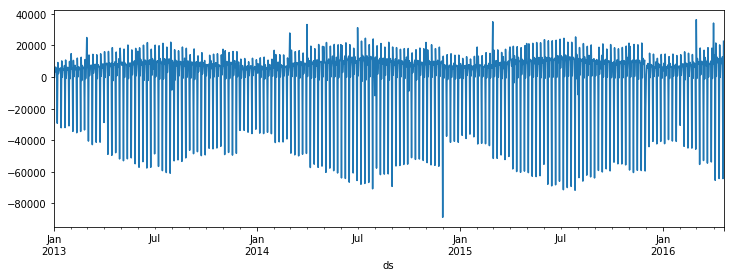

In [23]:
train.set_index('ds').diff(periods=1).plot(figsize=(12, 4), legend=False)
plt.show()

It's hard to see with so much data. Drilling in to narrower window will help to visualize the patterns more easily.  


2015 day-over-day difference: 

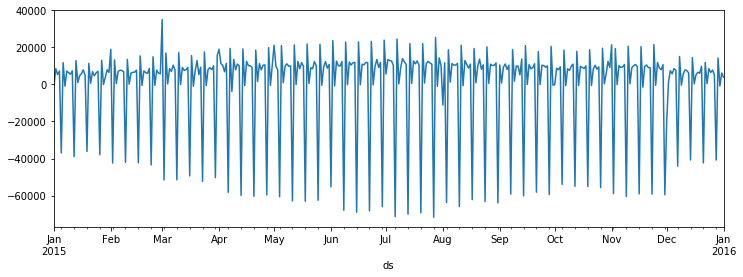

In [24]:
train.set_index('ds').diff(periods=1).loc['2015-01-01':'2016-01-01'].plot(figsize=(12, 4), legend=False)
plt.show()

I can see the patterns now, but I'd like to see them more clearly, so I will drill in to just a few weeks where there are no major holidays.  

Day-over-day difference 2015-09-13 (Sunday) through 2015-10-27 (Tuesday): 

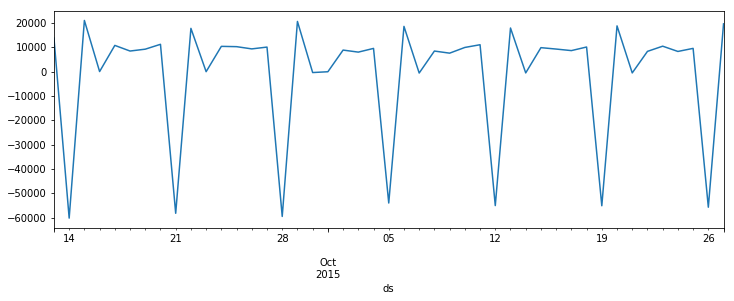

In [25]:
train.set_index('ds').diff(periods=1).loc['2015-09-13':'2015-10-27'].plot(figsize=(12, 4), legend=False)
plt.show()

#### Takeaways

- Dip on Mondays showing that generally about \\$50k to \\$60k more is sold on Sundays than Mondays. 
- Spike on Tuesdays indicates that about \\$20k more is sold on Tuesdays than on Mondays. 
- The drop to about \\$0 on Wednesdays indicates that about the same is sold on Wednesdays as on Tuesdays. 
- Sales increase on Thursdays by about \\$10k more than on Wednesdays. 
- Friday sales are another increase of about \\$10k from Thursdays. 
- Saturday sales are another increase of about \\$10k from Fridays.  
- Sunday sales are a slightly higher increase than Thursdays-Saturdays, but still hovering around the \\$10k delta. 
- All together, this translates to mean that the week starts with a major dip from Sunday into Monday. Tuesday shows significant increase in traffic from Monday, Wednesday looks the same as Tuesday, Thursday, Friday, Saturday and Sunday all increase at a somewhat steady pace to close out the week. 

